<a href="https://colab.research.google.com/github/asyrofist/Fundamental-Machine-Learning/blob/master/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summarization

In [0]:
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from operator import itemgetter
%matplotlib

Using matplotlib backend: Qt5Agg


In [0]:
sentences = brown.sents('ca01')

In [0]:
len(sentences)

98

In [0]:
[' '.join(sent) for sent in sentences]

["The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .",
 "The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .",
 "The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .",
 "`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' .",
 "The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and often ambiguous '' .",
 "It recommended that Fulton legisla

In [0]:
class TextCleaner():
    
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.punctuations = set(string.punctuation)
        self.pos_tags = {
                NOUN: ['NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRP$', 'WP', 'WP$'],
                VERB: ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                ADJ: ['JJ', 'JJR', 'JJS'],
                ADV: ['RB', 'RBR', 'RBS', 'WRB']
        }


    def _remove_stop_words(self, words):
        return [w for w in words if w not in self.stop_words]
     
    
    def _remove_regex(self):
        self.input_sent = " ".join([w.lower() for w in self.input_sent])
        self.input_sent = re.sub(r"i'm", "i am", self.input_sent)
        self.input_sent = re.sub(r"he's", "he is", self.input_sent)
        self.input_sent = re.sub(r"she's", "she is", self.input_sent)
        self.input_sent = re.sub(r"that's", "that is", self.input_sent)
        self.input_sent = re.sub(r"what's", "what is", self.input_sent)
        self.input_sent = re.sub(r"where's", "where is", self.input_sent)
        self.input_sent = re.sub(r"\'ll", " will", self.input_sent)
        self.input_sent = re.sub(r"\'ve", " have", self.input_sent)
        self.input_sent = re.sub(r"\'re", " are", self.input_sent)
        self.input_sent = re.sub(r"\'d", " would", self.input_sent)
        self.input_sent = re.sub(r"won't", "will not", self.input_sent)
        self.input_sent = re.sub(r"can't", "cannot", self.input_sent)
        self.input_sent = re.sub(r"don't", "do not", self.input_sent)
        patterns = re.finditer("#[\w]*", self.input_sent)
        for pattern in patterns:
            self.input_sent = re.sub(pattern.group().strip(), "", self.input_sent)
        self.input_sent = "".join(ch for ch in self.input_sent if ch not in self.punctuations)
    
    
    def _tokenize(self):
        return word_tokenize(self.input_sent)
    
    
    def _process_content_for_pos(self, words):
        tagged_words = pos_tag(words)
        pos_words = []
        for word in tagged_words:
            flag = False
            for key, value in self.pos_tags.items():
                if word[1] in value:
                    pos_words.append((word[0], key))
                    flag = True
                    break
            if not flag:
                pos_words.append((word[0], NOUN))
        return pos_words
       
                 
    def _remove_noise(self):
        self._remove_regex()
        words = self._tokenize()
        noise_free_words = self._remove_stop_words(words)
        return noise_free_words
    
    
    def _normalize_text(self, words):
        lem = WordNetLemmatizer()
        pos_words = self._process_content_for_pos(words)
        normalized_words = [lem.lemmatize(w, pos=p) for w, p in pos_words]
        return normalized_words
    
    
    def clean_up(self, input_sent):
        self.input_sent = input_sent
        cleaned_words = self._remove_noise()
        cleaned_words = self._normalize_text(cleaned_words)
        return cleaned_words

## PageRank Algorithm

In [0]:
def pagerank(M, eps=1.0e-8, d=0.85):
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    last_v = np.ones((N, 1), dtype=np.float32) * np.inf
    M_hat = (d * M) + (((1 - d) / N) * np.ones((N, N), dtype=np.float32))
    
    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = np.matmul(M_hat, v)
    return v

### Function to calculate cosine similarity among sentences

In [0]:
def sentence_similarity(sent1, sent2):
    text_cleaner = TextCleaner()
    
    sent1 = text_cleaner.clean_up(sent1)
    sent2 = text_cleaner.clean_up(sent2)
    
    all_words = list(set(sent1 + sent2))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    
    for w in sent1:
        vector1[all_words.index(w)] += 1
    
    for w in sent2:
        vector2[all_words.index(w)] += 1
    
    return 1 - cosine_distance(vector1, vector2)

### Similarity Adjacency Matrix for PageRank

In [0]:
def build_similarity_matrix(sentences):
    S = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i == j:
                continue
            else:
                S[i][j] = sentence_similarity(sentences[i], sentences[j])
    
    for i in range(len(S)):
        S[i] /= S[i].sum()
    return S

In [0]:
S = build_similarity_matrix(sentences)

In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asyrofi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [0]:
S

array([[0.        , 0.03809933, 0.03196713, ..., 0.01191345, 0.01459093,
        0.        ],
       [0.04793482, 0.        , 0.01714968, ..., 0.01278262, 0.01565545,
        0.        ],
       [0.07569435, 0.03227618, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02576081, 0.02196889, 0.        , ..., 0.        , 0.08413444,
        0.        ],
       [0.03354197, 0.02860469, 0.        , ..., 0.08944524, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [0]:
sentence_ranks = pagerank(S)

**Sentence Ranked according to their importance**

In [0]:
sentence_ranks

array([[0.01654559],
       [0.01488219],
       [0.01532134],
       [0.01557424],
       [0.01432059],
       [0.01327455],
       [0.00136336],
       [0.01657371],
       [0.01603994],
       [0.01438267],
       [0.01296925],
       [0.01395622],
       [0.00440929],
       [0.01018161],
       [0.00518729],
       [0.00016733],
       [0.01715976],
       [0.01289655],
       [0.00912811],
       [0.01041007],
       [0.00891017],
       [0.01323102],
       [0.01485767],
       [0.00348853],
       [0.01309149],
       [0.00080045],
       [0.00973098],
       [0.01271438],
       [0.01265435],
       [0.0085937 ],
       [0.01840167],
       [0.01552112],
       [0.00984595],
       [0.01365058],
       [0.01293599],
       [0.01589648],
       [0.00019401],
       [0.0173595 ],
       [0.01581783],
       [0.00923619],
       [0.01537113],
       [0.00013282],
       [0.01550033],
       [0.0149573 ],
       [0.00613643],
       [0.00103194],
       [0.00765428],
       [0.005

In [0]:
ranked_sentence_indexes = [item[0] for item in sorted(enumerate(sentence_ranks), key=lambda item: -item[1])]

In [0]:
ranked_sentence_indexes

[30,
 81,
 62,
 86,
 79,
 54,
 37,
 16,
 53,
 7,
 0,
 82,
 8,
 74,
 35,
 38,
 3,
 31,
 42,
 66,
 40,
 68,
 2,
 43,
 96,
 1,
 22,
 49,
 9,
 4,
 11,
 89,
 88,
 33,
 48,
 5,
 21,
 24,
 10,
 34,
 17,
 91,
 27,
 84,
 28,
 70,
 76,
 87,
 69,
 19,
 13,
 73,
 32,
 26,
 63,
 39,
 59,
 18,
 20,
 97,
 29,
 78,
 56,
 77,
 46,
 72,
 85,
 80,
 44,
 64,
 58,
 51,
 71,
 65,
 90,
 94,
 14,
 67,
 47,
 95,
 12,
 57,
 75,
 92,
 23,
 50,
 60,
 52,
 93,
 61,
 55,
 83,
 6,
 45,
 25,
 36,
 15,
 41]

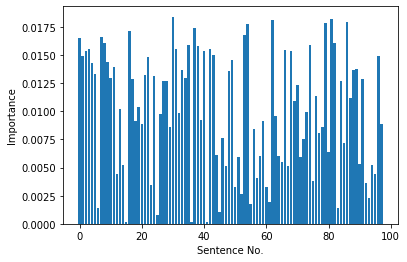

In [0]:
plt.bar([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks.T[0])
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

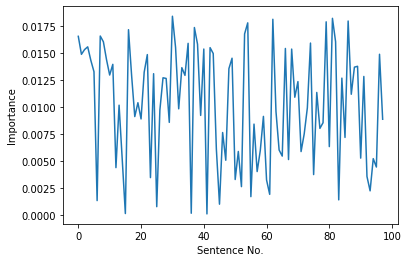

In [0]:
plt.plot([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks)
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

In [0]:
SUMMARY_SIZE = 5

In [0]:
selected_sentences = sorted(ranked_sentence_indexes[:SUMMARY_SIZE])

In [0]:
selected_sentences

[30, 62, 79, 81, 86]

In [0]:
summary = itemgetter(*selected_sentences)(sentences)

**Generated Summary**

In [0]:
for sent in summary:
    print(' '.join(sent))

Mayor William B. Hartsfield filed suit for divorce from his wife , Pearl Williams Hartsfield , in Fulton Superior Court Friday .
Meanwhile , it was learned the State Highway Department is very near being ready to issue the first $30 million worth of highway reconstruction bonds .
The resolution , which Barber tossed into the House hopper Friday , will be formally read Monday .
Colquitt
`` This was the coolest , calmest election I ever saw '' , Colquitt Policeman Tom Williams said .
